In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)
import seaborn as sns

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PowerTransformer

import lightgbm as lgbm


In [2]:
sys.path.append('../../')
import src.utils as utils

In [3]:
EXP_NUM = 1

In [4]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [5]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
seasons = pd.read_csv(MAIN_DATA_DIR / 'seasons.csv')


In [6]:
seasons = seasons.fillna('1970-01-01')
for c_ in seasons.columns[1:]:
    seasons[c_] = pd.to_datetime(seasons[c_].str.replace('-', '').astype(int), format="%Y%m%d")

In [7]:
seasons

,seasonId,seasonStartDate,seasonEndDate,preSeasonStartDate,preSeasonEndDate,regularSeasonStartDate,regularSeasonEndDate,lastDate1stHalf,allStarDate,firstDate2ndHalf,postSeasonStartDate,postSeasonEndDate
0,2017,2017-04-02,2017-11-01,2017-02-22,2017-04-01,2017-04-02,2017-10-01,2017-07-09,2017-07-11,2017-07-14,2017-10-03,2017-11-01
1,2018,2018-03-29,2018-10-28,2018-02-21,2018-03-27,2018-03-29,2018-10-01,2018-07-15,2018-07-17,2018-07-19,2018-10-02,2018-10-28
2,2019,2019-03-20,2019-10-30,2019-02-21,2019-03-26,2019-03-20,2019-09-29,2019-07-07,2019-07-09,2019-07-11,2019-10-01,2019-10-30
3,2020,2020-07-23,2020-10-28,2020-02-21,2020-07-22,2020-07-23,2020-09-27,2020-08-25,1970-01-01,2020-08-26,2020-09-29,2020-10-28
4,2021,2021-02-28,2021-10-31,2021-02-28,2021-03-30,2021-04-01,2021-10-03,2021-07-11,2021-07-13,2021-07-15,2021-10-04,2021-10-31


In [8]:
player_target_stats = pd.read_csv(MAIN_DATA_DIR / "player_target_stats.csv")

In [9]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

feature_cols1 = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

feature_cols2 = ['label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

feature_cols3 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

feature_cols4 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

In [10]:
oof = pd.read_csv('../40/output/oof40.csv')

In [11]:
oof

,Unnamed: 0,playerId,target1,target2,target3,target4,date
0,448,405395,1.280075,23.002584,0.698872,18.656340,20200801
1,449,405395,9.722412,33.291045,4.643390,19.931409,20200802
2,450,405395,0.666477,18.538190,0.693372,16.904704,20200803
3,451,405395,7.958543,31.736847,3.598884,19.267434,20200804
4,452,405395,1.292700,22.334275,0.698540,17.592181,20200805
...,...,...,...,...,...,...,...
178045,711008,685503,0.071790,1.400771,0.024576,0.629866,20210426
178046,711009,685503,0.047165,1.471522,0.019328,0.616443,20210427
178047,711010,685503,0.043253,2.100261,0.019283,0.610459,20210428
178048,711011,685503,0.039552,5.807171,0.020476,1.023793,20210429


In [12]:
targets

,engagementMetricsDate,playerId,target1,target2,target3,target4,index,date
0,2018-01-02,628317,0.011167,4.474708,0.005168,5.735294,0,20180101
1,2018-01-02,547989,0.042993,5.593385,0.045033,2.794118,0,20180101
2,2018-01-02,519317,0.974327,56.177043,13.693746,64.166667,0,20180101
3,2018-01-02,607625,0.006700,2.675097,0.005168,1.862745,0,20180101
4,2018-01-02,592547,0.001117,0.632296,0.002953,0.931373,0,20180101
...,...,...,...,...,...,...,...,...
2506171,2021-05-01,451661,0.000000,0.013314,0.000000,0.625925,1215,20210430
2506172,2021-05-01,519301,0.000131,0.003329,0.000000,0.216229,1215,20210430
2506173,2021-05-01,527055,0.000000,0.019971,0.000000,0.273131,1215,20210430
2506174,2021-05-01,543484,0.000131,0.056586,0.000000,1.024240,1215,20210430


In [13]:
oof = pd.merge(oof, targets, how='left', on=['playerId', 'date'])
oof

,Unnamed: 0,playerId,target1_x,target2_x,target3_x,target4_x,date,engagementMetricsDate,target1_y,target2_y,target3_y,target4_y,index
0,448,405395,1.280075,23.002584,0.698872,18.656340,20200801,2020-08-02,14.879888,32.858380,9.165873,17.559039,943
1,449,405395,9.722412,33.291045,4.643390,19.931409,20200802,2020-08-03,28.667544,16.654957,15.650256,16.562293,944
2,450,405395,0.666477,18.538190,0.693372,16.904704,20200803,2020-08-04,17.100412,30.321622,4.801026,73.074653,945
3,451,405395,7.958543,31.736847,3.598884,19.267434,20200804,2020-08-05,41.767578,66.553354,14.135787,60.960068,946
4,452,405395,1.292700,22.334275,0.698540,17.592181,20200805,2020-08-06,3.063820,21.803628,0.996215,35.158835,947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178045,711008,685503,0.071790,1.400771,0.024576,0.629866,20210426,2021-04-27,0.044617,1.224728,0.009437,0.737463,1211
178046,711009,685503,0.047165,1.471522,0.019328,0.616443,20210427,2021-04-28,0.019123,1.178880,0.013161,0.790301,1212
178047,711010,685503,0.043253,2.100261,0.019283,0.610459,20210428,2021-04-29,0.015799,4.323489,0.002350,0.970273,1213
178048,711011,685503,0.039552,5.807171,0.020476,1.023793,20210429,2021-04-30,0.018770,31.946021,0.305491,5.938273,1214


In [17]:
oof = pd.merge(oof, scores, how='left', on=['playerId', 'date']) 


In [21]:
oof['gameday'] = oof['battingOrder'].isna()*1

In [24]:
len(oof[oof['gameday'] ==1]), len(oof[oof['gameday'] ==0])

(145967, 32083)

In [22]:
mae = mean_absolute_error(oof[oof['gameday']==1].iloc[:, 2:6], oof[oof['gameday']==1].iloc[:, 8:12])
print("mae:", mae)

mae: 1.2071068738829311


In [23]:
mae = mean_absolute_error(oof[oof['gameday']==0].iloc[:, 2:6], oof[oof['gameday']==0].iloc[:, 8:12])
print("mae:", mae)

mae: 2.621879800004172


In [22]:
from scipy import stats

0.5775100972283256

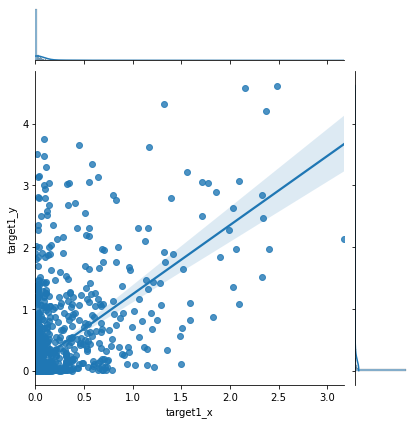

In [32]:
x_ = np.log(oof["target1_x"][::100]+1)
y_ = np.log(oof["target1_y"][::100]+1)
sns.jointplot(x=x_, y=y_, kind="reg")
np.corrcoef(x_, y_)[0, 1]

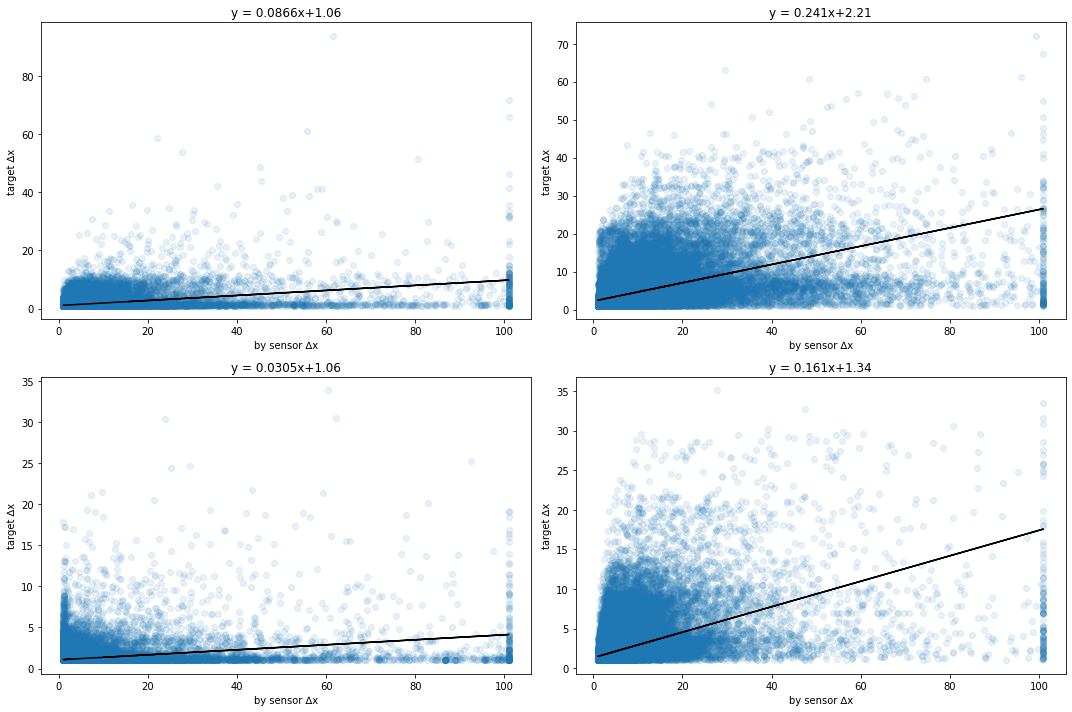

In [53]:
from sklearn import linear_model


fig = plt.figure(figsize=(15, 10))

target_x = (oof["target1_x"]+1).values.reshape(-1,1)
pred_x = (oof["target1_y"]+1).values.reshape(-1,1)
reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)
ax1 = fig.add_subplot(221)
ax1.plot(pred_x, reg1.predict(pred_x), color='black')
ax1.scatter(pred_x, target_x, alpha=0.1)
ax1.set_xlabel('by sensor ∆x')
ax1.set_ylabel('target ∆x')
ax1.set_title('y = {:.3g}x+{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))


target_x = (oof["target2_x"]+1).values.reshape(-1,1)
pred_x = (oof["target2_y"]+1).values.reshape(-1,1)
reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)
ax2 = fig.add_subplot(222)
ax2.plot(pred_x, reg1.predict(pred_x), color='black')
ax2.scatter(pred_x, target_x, alpha=0.1)
ax2.set_xlabel('by sensor ∆x')
ax2.set_ylabel('target ∆x')
ax2.set_title('y = {:.3g}x+{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))

target_x = (oof["target3_x"]+1).values.reshape(-1,1)
pred_x = (oof["target3_y"]+1).values.reshape(-1,1)
reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)
ax3 = fig.add_subplot(223)
ax3.plot(pred_x, reg1.predict(pred_x), color='black')
ax3.scatter(pred_x, target_x, alpha=0.1)
ax3.set_xlabel('by sensor ∆x')
ax3.set_ylabel('target ∆x')
ax3.set_title('y = {:.3g}x+{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))

target_x = (oof["target4_x"]+1).values.reshape(-1,1)
pred_x = (oof["target4_y"]+1).values.reshape(-1,1)
reg1 = linear_model.LinearRegression()
reg1.fit(pred_x, target_x)
ax4 = fig.add_subplot(224)
ax4.plot(pred_x, reg1.predict(pred_x), color='black')
ax4.scatter(pred_x, target_x, alpha=0.1)
ax4.set_xlabel('by sensor ∆x')
ax4.set_ylabel('target ∆x')
ax4.set_title('y = {:.3g}x+{:.3g}'.format(reg1.coef_[0][0], reg1.intercept_[0]))

plt.tight_layout()